In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
import h5py

## Read in data and bootstrap

In [2]:
# File with effective mass output.
ftype = 'h5'
base = 'output/'
# cfg = 'cl3_16_48_b6p1_m0p2450_output9622'
cfg = 'cl3_16_48_b6p1_m0p2450_output1693'
file = base + cfg + '.' + ftype

## Read in file

In [3]:
L3 = 48    #temporal extent of lattice
C = []
if ftype == 'txt':
    f = open(file, 'r')
    # New read in format: Each line after the first of form cfgId|a1+ib a2+ib ...
    f.readline()
    for i, line in enumerate(f):
        # if i not in sample_ids:
        #     continue
        cur_line = np.zeros(L3, dtype=complex)
        cfgIdx, rest = line.split('|')
        cfgIdx = int(cfgIdx)
        interps = rest.split(' ')    # now get real and complex
        for n_t, x in enumerate(interps):
            if not x.isspace():
                real, imag = x.split('+i(')    #form should be x = a+i(b)
                real = float(real)
                imag = float(imag.replace(')', ''))
                cur_line[n_t] = complex(real, imag)
        cur_line = [cur_line]
        if C == []:
            C = np.array(cur_line)
        else:
            C = np.append(C, cur_line, axis = 0)
elif ftype == 'h5':
    f = h5py.File(file, 'r')
    correlators = f['twopt']
    for i, data in correlators.items():
        if C == []:
            C = np.array(data)
        else:
            C = np.vstack([C, data])
else:
    raise Exception("File type cannot be read in.")

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [4]:
def bootstrap(C, n_boot = 500):
    num_configs = C.shape[0]
    n_t = C.shape[1]
    samples = np.zeros((n_boot, num_configs, n_t), dtype = complex)
    for i in range(n_boot):
        cfgIds = np.random.choice(num_configs, num_configs)    #Configuration ids to pick
        samples[i, :, :] = C[cfgIds, :]
    return samples

In [5]:
num_configs = C.shape[0]
n_t = C.shape[1]
samples = bootstrap(C)
print(samples.shape)

(500, 252, 48)


## Compute correlation function and effective mass

In [6]:
# Compute ensemble average of each correlation function
ensemble_avg = np.mean(samples, axis = 1)
μ_C = np.abs(np.mean(ensemble_avg, axis = 0))
σ_C = np.abs(np.std(ensemble_avg, axis = 0))

In [7]:
# Compute effective mass
ratios = np.abs(ensemble_avg / np.roll(ensemble_avg, shift = -1, axis = 1))[:, :-1]
m_eff_ensemble = np.log(ratios)
μ_m_eff = np.mean(m_eff_ensemble, axis = 0)
σ_m_eff = np.std(m_eff_ensemble, axis = 0, ddof = 1)

In [8]:
# Compute cosh-corrected effective mass
N = 48
cosh_m_eff_ensemble = np.zeros(ratios.shape)
for ens_idx in range(ratios.shape[0]):
    for t in range(ratios.shape[1]):
        m = root(lambda m : ratios[ens_idx, t] - np.cosh(m * (t - N / 2)) / np.cosh(m * (t + 1 - N / 2)), \
                     m_eff_ensemble[ens_idx, t])
        cosh_m_eff_ensemble[ens_idx, t] = m.x
μ_cosh = np.mean(cosh_m_eff_ensemble, axis = 0)
σ_cosh = np.std(cosh_m_eff_ensemble, axis = 0, ddof = 1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in cosh
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


<IPython.core.display.Javascript object>


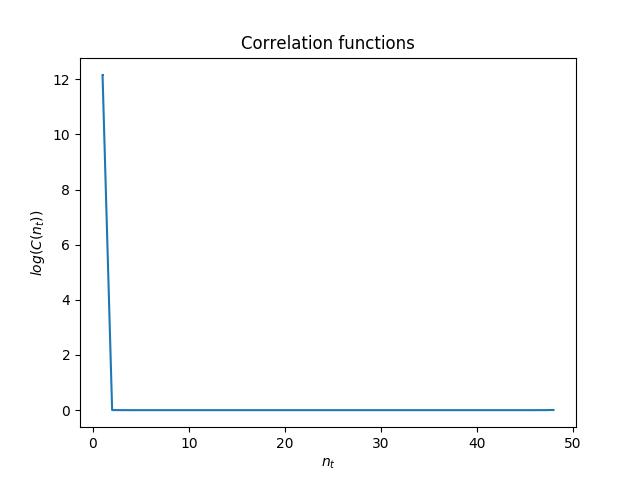

Text(0, 0.5, '$log(C(n_t))$')

In [19]:
plt.figure()
plt.errorbar(range(1, n_t + 1), μ_C, yerr = σ_C)
plt.yscale('log')
plt.title('Correlation functions')
plt.xlabel('$n_t$')
plt.ylabel('$log(C(n_t))$')

<IPython.core.display.Javascript object>


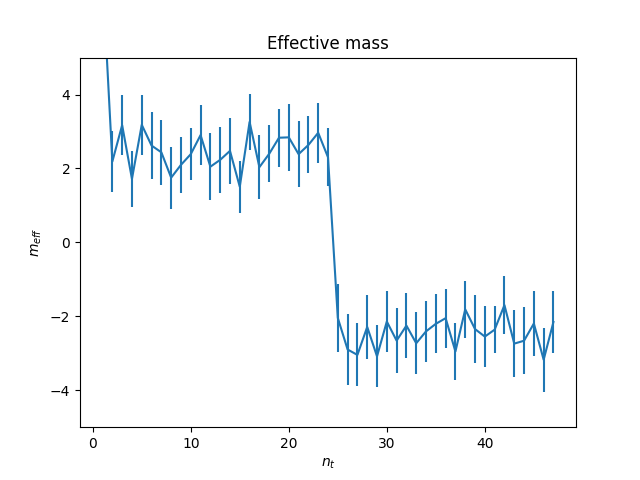

Text(0, 0.5, '$m_{eff}$')

In [18]:
plt.figure()
plt.errorbar(range(1, n_t), μ_m_eff, yerr = σ_m_eff)
plt.title('Effective mass')
plt.ylim((-5, 5))
plt.xlabel('$n_t$')
plt.ylabel('$m_{eff}$')

<IPython.core.display.Javascript object>


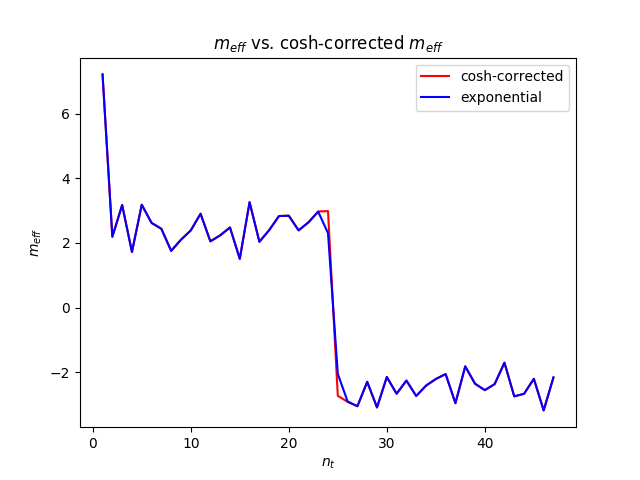

In [16]:
plt.figure()
plt.plot(range(1, n_t), μ_cosh, 'r', label = 'cosh-corrected')
plt.plot(range(1, n_t), μ_m_eff, 'b', label = 'exponential')

plt.title('$m_{eff}$ vs. cosh-corrected $m_{eff}$')
# plt.ylim((-3, 3))
plt.xlabel('$n_t$')
plt.ylabel('$m_{eff}$')
plt.legend()

plt.show()

In [12]:
# plt.savefig('/Users/theoares/lqcd/pion_mass/output/' + cfg + '.png')

## Determine error scaling

In [13]:
base_time = 15
cfg_list = range(10, num_configs, 10)
err = np.zeros(len(cfg_list))
means = np.zeros(len(cfg_list))
for i, n in enumerate(cfg_list):    # sample n configurations from C
    config_ids = np.random.choice(num_configs, n, replace = False)
    C_sub = C[config_ids, :]    #now get error on the subsampled C
    subensemble = bootstrap(C_sub)
    subensemble_avg = np.mean(subensemble, axis = 1)
    μ = np.abs(np.mean(subensemble_avg, axis = 0))
    σ = np.abs(np.std(subensemble_avg, axis = 0))
    err[i] = σ[base_time]
    means[i] = μ[base_time]

In [14]:
print('Errors are: ', err)
print('Average correlation function is: ', means)

Errors are:  [8.66453802e-17 1.07299543e-16 7.77343942e-17 7.30424393e-17
 6.49453027e-17 5.51522469e-17 5.13770947e-17 4.82588385e-17
 4.64259719e-17 4.51747209e-17 3.76314053e-17 4.08330891e-17
 3.96151821e-17 3.61111635e-17 3.87809873e-17 3.53413665e-17
 3.18280661e-17 3.54436228e-17 3.44445508e-17 3.02010664e-17
 3.08960825e-17 3.02541132e-17 2.92972467e-17 2.81725975e-17
 2.76801509e-17]
Average correlation function is:  [7.24030634e-17 5.58005972e-17 1.81556225e-16 1.42987580e-16
 2.63497772e-17 5.08921966e-17 6.62748515e-17 8.17080173e-17
 6.87896583e-17 6.35926675e-17 4.41082041e-17 9.63034664e-17
 2.85171546e-17 7.18146606e-17 5.48519028e-17 7.99069283e-17
 3.43893608e-17 6.36092497e-17 4.64785096e-17 5.44216970e-17
 5.28128439e-17 5.03601456e-17 5.37425014e-17 5.43626433e-17
 5.36635763e-17]


<IPython.core.display.Javascript object>


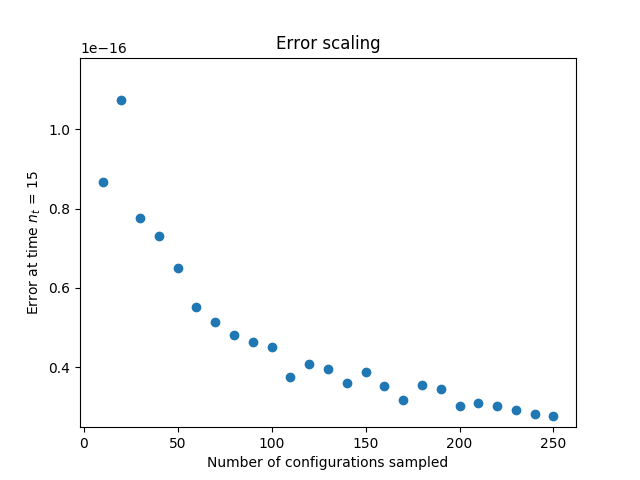

In [15]:
plt.figure()
plt.scatter(cfg_list, err)
plt.title('Error scaling')
plt.xlabel('Number of configurations sampled')
plt.ylabel('Error at time $n_t$ = ' + str(base_time))
# plt.ylim((1e-18, 1e-17))
plt.ylim((.9 * np.min(err), 1.1 * np.max(err)))
plt.show()